##### Python imports:

In [1]:
from threading import Thread
import time
import os

##### ROS Specific Imports:

In [2]:
import rospy
import actionlib
from assignment_2_2022.msg import PlanningAction, PlanningGoal
from unige_rt1_assignment2.srv import GoalInfo
from unige_rt1_assignment2.msg import RoboStatusMsg
from sensor_msgs.msg import LaserScan

from nav_msgs.msg import Odometry

##### Jupyter and Widgets imports

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.display import HTML
from ipywidgets import Layout

##### Imports for plotting and visualizations

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tf
from tf.transformations import quaternion_matrix
import numpy as np

%matplotlib widget

##### Plotting Class for the Robot real-time position and goal position.

In [5]:
class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln

    def odom_callback(self, msg):
        """
        Function to get and plot on the same plot the robot position from the odometry topic.
        """
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

    def get_goal_pos(self):
        """
        Function to get and plot on the same plot the goal position from the parameter server.
        """
        self.x_goal_pos = rospy.get_param("/robot/goal_pos_param/x_goal")
        self.y_goal_pos = rospy.get_param("/robot/goal_pos_param/y_goal")
        self.ax.plot(self.x_goal_pos, self.y_goal_pos, 'bo')
        
    def update_plot(self, frame):
        """
        Function to update the plot.
        """
        self.ln.set_data(self.x_data, self.y_data)
        self.get_goal_pos()
        self.fig.canvas.draw()
        return self.ln

##### Plotting class for the goals reached and cancelled. Real-time pie chart.

In [6]:
class goal_info_plot:
    # Animated pie chart for goals reached and cancelled
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.labels = ['Goals Reached', 'Goals Cancelled']
        self.colors = ['green', 'red']
        self.goals_data = [1]  # Initialize with a single category
        self.wedges, self.texts, self.autotexts = self.ax.pie(self.goals_data, colors=['darkviolet'], labels=['Violet-disk! => no goals yet.'], autopct='%1.1f%%')
        self.ax.axis('equal')

    def update_plot(self, reached, cancelled):
        """
        Function to update the plot.
        """
        self.ax.clear()
        if reached or cancelled:  # if at least one value is non-zero
            self.goals_data = [reached, cancelled]
            self.wedges, self.texts, self.autotexts = self.ax.pie(self.goals_data, labels=self.labels, colors=self.colors, autopct='%1.1f%%')
        else:  # if both values are zero
            self.goals_data = [1]
            self.wedges, self.texts, self.autotexts = self.ax.pie(self.goals_data, colors=['darkviolet'], labels=['Violet-disk! => no goals yet.'], autopct='%1.1f%%')
        self.ax.axis('equal')
        self.fig.canvas.draw()


##### Visualization Class for the Laser Scan:

In [7]:
class LaserScanVis:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'b.')
        self.angle_data = []
        self.range_data = []

    def plot_init(self):
        """
        Function to initialize the plot.
        """
        self.ax.set_xlim(-7,7)
        self.ax.set_ylim(-7,7)
        return self.ln

    def laser_scan_callback(self, msg):
        """
        Function to get and plot on the same plot the laser scan data.
        """
        angle_increment = msg.angle_increment
        self.angle_data = [msg.angle_min + i * angle_increment for i in range(len(msg.ranges))]
        self.range_data = msg.ranges
    
    def update_plot(self, frame):
        """
        Function to update the plot.
        """
        x_data = [r * np.cos(theta) for r, theta in zip(self.range_data, self.angle_data)]
        y_data = [r * np.sin(theta) for r, theta in zip(self.range_data, self.angle_data)]
        self.ln.set_data(x_data, y_data)
        return self.ln,

##### The RoboClient class is the main class of the node. It is responsible for the communication with the server and the visualization of the robot and the laser scan.

In [8]:
class RoboClient:
    def __init__(self):
        rospy.init_node('robo_client', anonymous=True)
        
        # Service client to get the goals info
        self.goal_info_client = rospy.ServiceProxy("/goals_service", GoalInfo)

        # Dictionary to store the robot position
        self. robo_position = {
            "x": 0.0,
            "y": 0.0
        }
        # Subscriber to get the robot position
        self.robo_position_sub = rospy.Subscriber("/robot/robo_stats", RoboStatusMsg, self.robo_position_callback)

        # variable to store the closest obstacle, defined as infinity at the beginning
        self.closest_obstacle = float("inf")
        # Subscriber to get the laser scan information for distance to obstacles
        self.laser_scan_sub = rospy.Subscriber("/scan", LaserScan, self.laser_scan_callback)

        # Action client to send the goals
        self.target_ac = actionlib.SimpleActionClient("/reaching_goal", PlanningAction)
        rospy.loginfo("Waiting for action server to start.")
        self.target_ac.wait_for_server()
        rospy.loginfo("Action server started!")

        # Initialize the (odom) Visualizer
        self.vis = Visualiser()
        self.vis_sub = rospy.Subscriber("/odom", Odometry, self.vis.odom_callback)
        self.vis_ani = FuncAnimation(self.vis.fig, self.vis.update_plot, init_func=self.vis.plot_init, cache_frame_data=False)

        # Initialize Laser Scan (obstacle) visualizer
        self.vis_laserscan = LaserScanVis()
        self.laser_sub = rospy.Subscriber("/scan", LaserScan, self.vis_laserscan.laser_scan_callback)
        self.laser_ani = FuncAnimation(self.vis_laserscan.fig, self.vis_laserscan.update_plot, init_func=self.vis_laserscan.plot_init, cache_frame_data=False)


    def send_goal(self, x, y):
        """
        Function to send a goal to the action server.
        """
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = x
        goal.target_pose.pose.position.y = y
        self.target_ac.send_goal(goal, done_cb=self.goal_task_fin_cb)

        if rospy.has_param("/robot/goal_pos_param"):
            rospy.set_param("/robot/goal_pos_param/x_goal", x)
            rospy.set_param("/robot/goal_pos_param/y_goal", y)
        else:
            rospy.logerr("Goal position parameter not found on the parameter server.")

    def cancel_goal(self):
        """
        Function to cancel the current goal.
        """
        if self.target_ac.get_state() == actionlib.GoalStatus.ACTIVE:
            print("Cancelling current goal...")
            self.target_ac.cancel_goal()
        else:
            print("No goal is currently executing.")
    
    def goal_task_fin_cb(self, state, result):
        if state == actionlib.GoalStatus.SUCCEEDED:
            print("Goal reached!")
            send_button.layout.visibility = 'visible'
            cancel_button.layout.visibility = 'hidden'
        elif state == actionlib.GoalStatus.PREEMPTED:
            print("Goal cancelled!")
            send_button.layout.visibility = 'visible'
            cancel_button.layout.visibility = 'hidden'

    def get_goal_info(self):
        try:
            goals_info_response = self.goal_info_client()
            return goals_info_response.msg_feedback
        except rospy.ServiceException as e:
            print("Service call failed: %s"%e)
            return None

    def robo_position_callback(self, msg):
        self.robo_position["x"] = msg.pos_x
        self.robo_position["y"] = msg.pos_y
    
    def get_robo_position(self):
        return self.robo_position["x"], self.robo_position["y"]

    def laser_scan_callback(self, msg):
        self.closest_obstacle = min(msg.ranges)

    def get_closest_obstacle(self):
        return self.closest_obstacle

    def spin(self):
        rospy.spin()

#### This cell is to:
    + Instantiate the RoboClient class (initializing the node)
    + Definitions for the button send and cancel button callbacks

[INFO] [1685641018.621900, 1224.108000]: Waiting for action server to start.
[INFO] [1685641018.676482, 1224.159000]: Action server started!


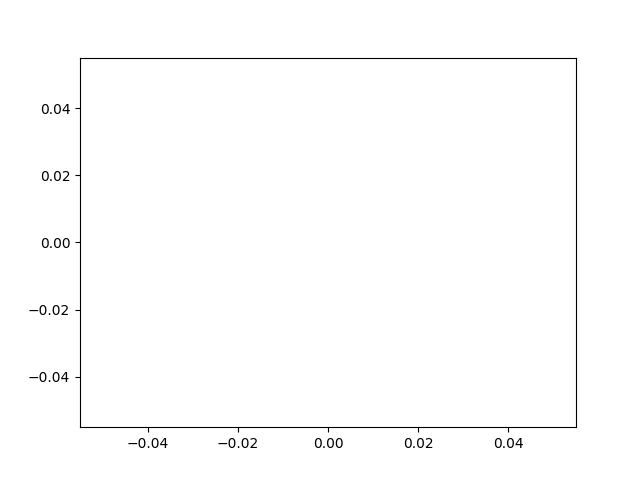

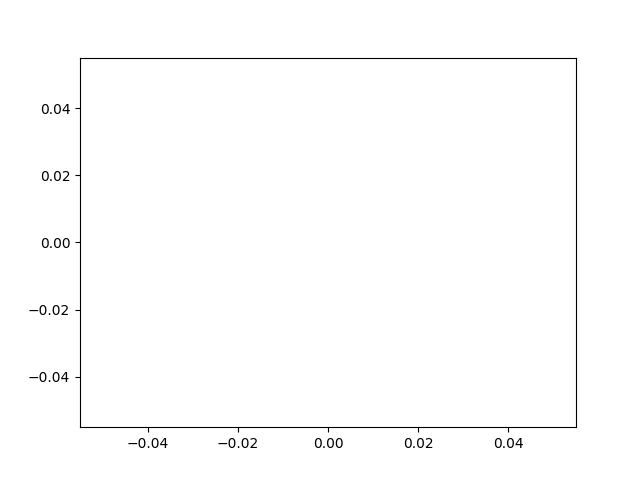

Goal cancelled!


In [9]:
robo_client = RoboClient()

def on_send_button_click(button):
    """
    Function to send a goal to the action server.
    """
    x = float(x_text.value)
    y = float(y_text.value)
    robo_client.send_goal(x, y)
    print(f"Sending new goal: ({x}, {y})")

    # hide send button, reveal the cancel button
    send_button.layout.visibility = 'hidden'
    cancel_button.layout.visibility = 'visible'

def on_cancel_button_click(button):
    """
    Function to cancel the current goal.
    """
    robo_client.cancel_goal()

    # hide cancel button, reveal the send button
    cancel_button.layout.visibility = 'hidden'
    send_button.layout.visibility = 'visible'

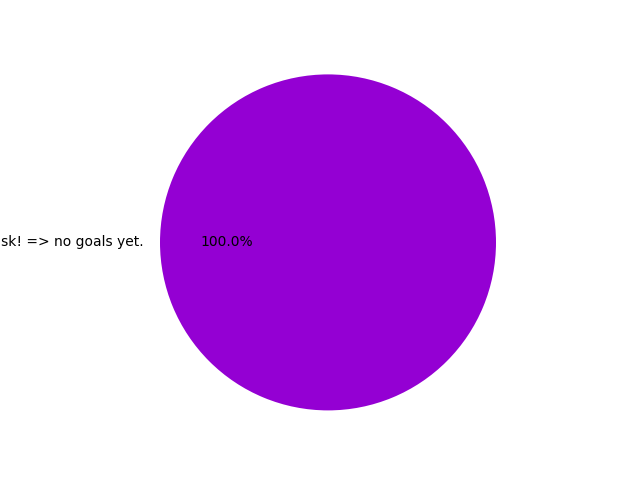

Sending new goal: (6.0, 3.0)
Cancelling current goal...


In [10]:
# Information Display UI

# layout style
layout = Layout(
    display='flex',
    flex_flow='column',
    align_items='center',  # To center align the box
    justify_content='center',
    border='solid',
    width='50%',
    padding='10px',
    margin='auto'
)

# Some CSS Styling used to improve the UI and show the power of HTML in Jupyter Widgets
style = """
<style>
    p {
        font-size: 18px;
        color: #4B0082;  # Indigo text
        font-family: Arial, sans-serif;
    }
    .widget-box {
        background-color: #F0F8FF;  # AliceBlue background
        border-radius: 5px;
        box-shadow: 2px 2px 2px lightgray;
    }
    input[type='text'] {
        padding: 10px;
        border-radius: 5px;
        border: 1px solid #4B0082;
    }
    .button {
        background-color: #4B0082;
        border: none;
        color: white;
        padding: 10px 20px;
        text-align: center;
        text-decoration: none;
        display: inline-block;
        font-size: 16px;
        margin: 4px 2px;
        cursor: pointer;
        border-radius: 5px;
    }
</style>
"""


# Widget to display the robot position
robo_pos_widget_label = widgets.HTML(value=f"{style}<p><b>Robot position:</b> N/A</p>")

# Widget to display the closest obstacle
closest_obstacle_widget_label = widgets.HTML(value=f"{style}<p><b>Distance to closest obstacle:</b> N/A</p>")

# Jupyter widget for goals reached and cancelled
goal_info_widget_label = widgets.HTML(value=f"{style}<p><b>Goals Information:</b> N/A</p>")

# Combine the labels into a single UI using a VBox
info_ui = widgets.VBox([robo_pos_widget_label, closest_obstacle_widget_label, goal_info_widget_label], layout=layout)

# CSS Class addition for VBox UI
info_ui.add_class('widget-box')

# heading
heading = widgets.HTML(value="<center><h2 style='color: #4B0082;'><u>Robot Controller Interface</u></h2></center>")

# Text input fields for X and Y
x_text = widgets.FloatText(description="X:")
y_text = widgets.FloatText(description="Y:")

# Buttons for send and cancel
send_button = widgets.Button(description="Send Goal", button_style='success')  # 'success' for green color
cancel_button = widgets.Button(description="Cancel Goal", button_style='danger')  # 'danger' for red color

# on-click events callback functions
send_button.on_click(on_send_button_click)
cancel_button.on_click(on_cancel_button_click)

# Combine the input fields and buttons into a single UI using an HBox
goal_ui = widgets.HBox([x_text, y_text, send_button, cancel_button])

# Combine the goal UI and the information UI into a single UI using a VBox
combined_ui = widgets.VBox([heading, goal_ui, info_ui], layout=Layout(display='flex', flex_flow='column', align_items='center', justify_content='center'))

display(combined_ui)

goals_completion_graph = goal_info_plot()

In [11]:
def updated_robo_position():
    """
    Function to update the robot position and closest obstacle widgets.
    """
    while not rospy.is_shutdown():
        robo_x_pos, robo_y_pos = robo_client.get_robo_position()
        robo_pos_widget_label.value = f"Robot position: ({robo_x_pos:.2f}, {robo_y_pos:.2f})"

        closest_obstacle_dist = robo_client.get_closest_obstacle()
        closest_obstacle_widget_label.value = f"Distance to closest obstacle: {closest_obstacle_dist:.2f}"

        rospy.sleep(0.75)

# Thread to update the robot position and closest obstacle widgets
position_thread = Thread(target=updated_robo_position)
position_thread.start()

In [12]:
def update_goal_info():
    """
    Function to update the goal info widget.
    """
    while not rospy.is_shutdown():
        goal_info = robo_client.get_goal_info()
        if goal_info is not None:
            """
            Extract the goals reached and cancelled from the goal info which returns a string of type
            "\n==========================================\nNumber of goals reached: " + std::to_string(goals_reached) + "\nNumber of goals cancelled: " + std::to_string(goals_cancelled) + "\n==========================================\n"
            """
            goal_info = goal_info.split("\n")
            goals_reached = int(goal_info[2].split(":")[1])
            goals_cancelled = int(goal_info[3].split(":")[1])

            goal_info_widget_label.value = f"Goals Information: Reached Goals: {goals_reached}, Cancelled Goals: {goals_cancelled}"

            # Plot the goal info using the goal_info_plot class
            goals_completion_graph.update_plot(goals_reached, goals_cancelled)

        rospy.sleep(0.75)

# Thread to update the goal info widget
goal_info_thread = Thread(target=update_goal_info)
goal_info_thread.start()